# Two Digit Recognition(extended from single Digit) using MNIST dataset


## Introduction
In this notebook, we solve the Kaggle-MNIST Digit Recognizer competition using Convolutional Neural Networks (CNNs).
This approach leverages the power of CNNs to classify handwritten digit images from the MNIST dataset.
We'll cover data visualization, preprocessing, model building, training, and evaluation.
- We take the MNIST single digit dataset and convert that to two digit dataset by horizontal concatenation and run CNN model on that

## Data Loading
We first load and inspect the training and test datasets.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical

# Load the data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Display the first few rows of the training dataset to understand its structure
train_data.head()


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
# Display the first few rows of the test dataset to understand its structure
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Extend this solution for two digits
- Using randomly selected record of single digit and applying horizontal concatenation

In [3]:
import pandas as pd
import numpy as np

# Separate labels and pixel data in the training data
train_labels = train_data['label'].values
train_pixels = train_data.drop(columns=['label']).values

# Pixel data in the test data (no labels)
test_pixels = test_data.values

# Function to create a dataset with paired images
def create_two_digit_dataset(labels, pixels, purpose, num_samples):
    paired_data = []
    paired_labels = []

    for _ in range(num_samples):
        # Randomly select two indices for pairing
        idx1, idx2 = np.random.choice(len(pixels), 2, replace=False)

        # Get the images and labels at the selected indices
        img1, img2 = pixels[idx1], pixels[idx2]
        if purpose == 'train':
          label1, label2 = labels[idx1], labels[idx2] if len(labels) else ("", "")

        # Reshape each image to 28x28
        img1_matrix = img1.reshape(28, 28)
        img2_matrix = img2.reshape(28, 28)

        # Concatenate images horizontally row-by-row
        combined_image = np.hstack((img1_matrix, img2_matrix)).flatten()  # Shape becomes (28, 56) then flattened to (1564,)
        if purpose == 'train':
          combined_label = str(label1) + str(label2) if len(labels) else ""

        # Append to the list
        paired_data.append(combined_image)
        if purpose == 'train' :
          paired_labels.append(combined_label)

    # Create a DataFrame
    paired_df = pd.DataFrame(paired_data, columns=[f'pixel_{i}' for i in range(1568)])
    if len(labels):  # Only add labels for training data
        paired_df.insert(0, 'label', paired_labels)

    return paired_df

# Create datasets for train and test
two_digit_train_df = create_two_digit_dataset(train_labels, train_pixels, "train", num_samples=99000)
two_digit_test_df = create_two_digit_dataset([], test_pixels, "test", num_samples=20000)

# Display the first few rows of each dataset to check the structure
print("Two-digit Training Data:")
print(two_digit_train_df.head())
print("\nTwo-digit Test Data:")
print(two_digit_test_df.head())

Two-digit Training Data:
  label  pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  \
0    82      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1    25      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2    13      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3    42      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4    46      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   pixel_7  pixel_8  ...  pixel_1558  pixel_1559  pixel_1560  pixel_1561  \
0      0.0      0.0  ...         0.0         0.0         0.0         0.0   
1      0.0      0.0  ...         0.0         0.0         0.0         0.0   
2      0.0      0.0  ...         0.0         0.0         0.0         0.0   
3      0.0      0.0  ...         0.0         0.0         0.0         0.0   
4      0.0      0.0  ...         0.0         0.0         0.0         0.0   

   pixel_1562  pixel_1563  pixel_1564  pixel_1565  pixel_1566  pixel_1567


## Data Visualization
Let's visualize the distribution of digit labels in the training dataset.
This helps us understand the dataset better and check for any imbalance.


label
12    1313
21    1313
11    1278
22    1265
20    1246
      ... 
35     814
73     776
53     773
38     773
33     658
Name: count, Length: 100, dtype: int64


<ipython-input-4-2716591748>:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='label', bbox_to_anchor=(1.05, 1), loc='upper left')


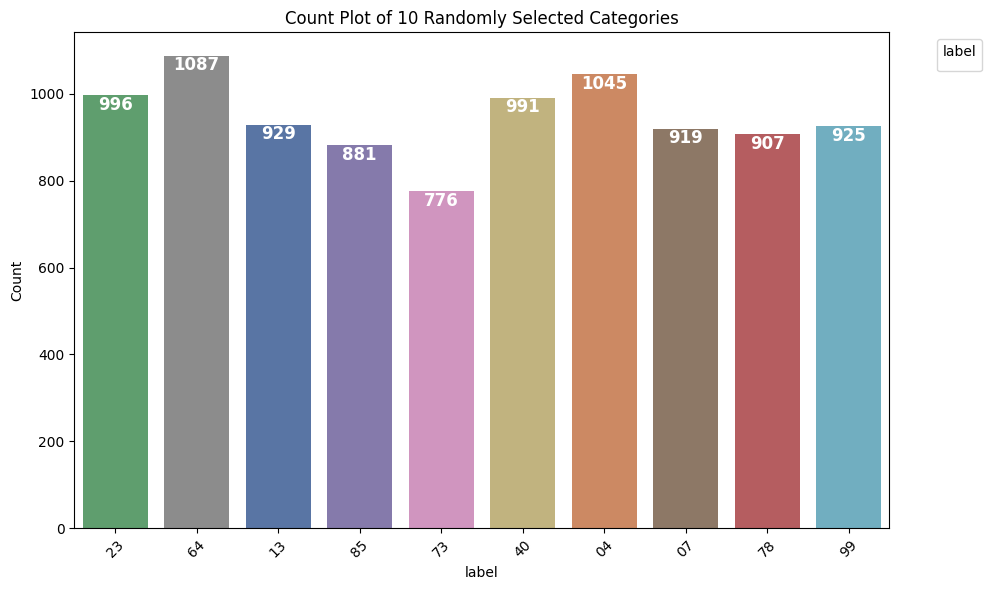

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
print(two_digit_train_df['label'].value_counts())

# Generate sample dataset with 100 unique categories and random counts
np.random.seed(0)  # For reproducibility

# Randomly select 10 categories from the 100 unique values
sampled_categories = np.random.choice(two_digit_train_df['label'].unique(), 10, replace=False)

# Filter the dataset to include only the sampled categories
sampled_data = two_digit_train_df[two_digit_train_df['label'].isin(sampled_categories)]

# Plot countplot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=sampled_data, x='label', palette='deep', hue = 'label', order=sampled_categories)

# Annotate counts inside each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2, p.get_height() - 1),  # Position within bar
                ha='center', va='top', color='white', fontsize=12, fontweight='bold')
plt.legend(title='label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Count Plot of 10 Randomly Selected Categories')
plt.xlabel('label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



### Sample Digit Images
We plot some sample images from the training dataset to see the handwritten digits.


In [5]:
two_digit_train_df['label'] = two_digit_train_df['label'].astype(int)
two_digit_train_df.dtypes

,0
label,int64
pixel_0,float64
pixel_1,float64
pixel_2,float64
pixel_3,float64
...,...
pixel_1563,float64
pixel_1564,float64
pixel_1565,float64
pixel_1566,float64


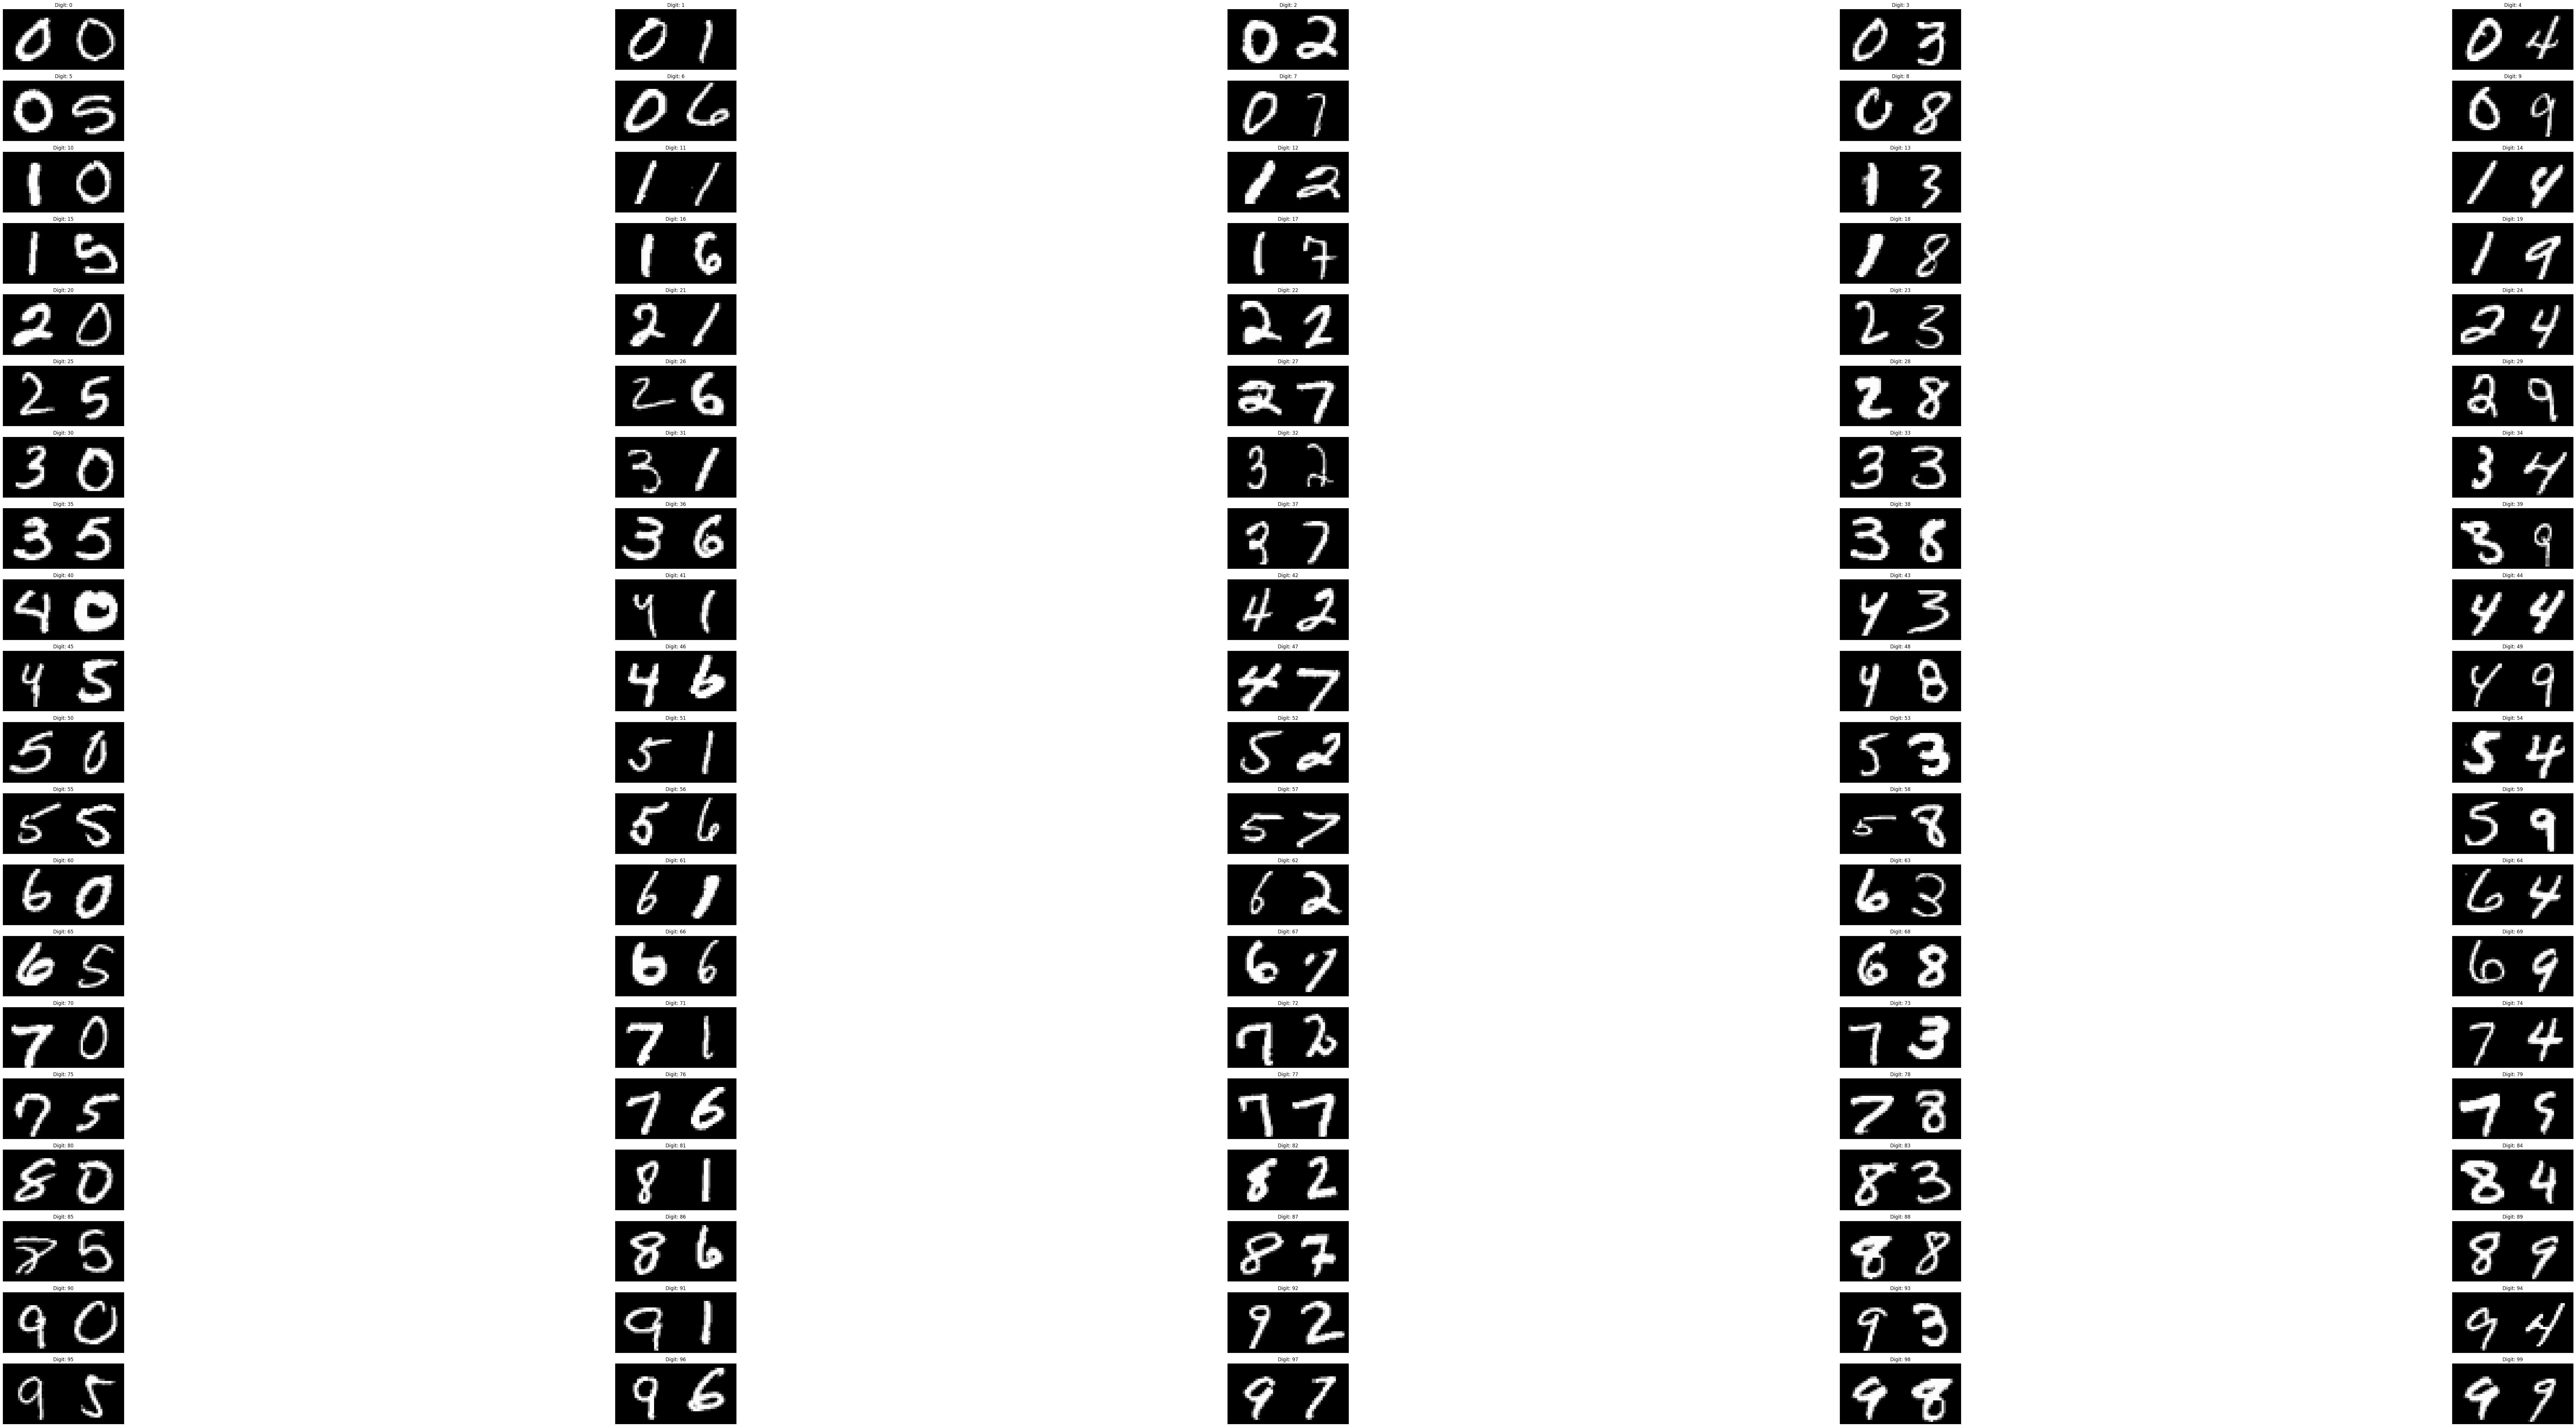

In [6]:
# Plot sample images
fig, axes = plt.subplots(20, 5, figsize=(120, 50))
axes = axes.ravel()

for i in range(100):
    img = two_digit_train_df[two_digit_train_df['label'] == i].iloc[0, 1:].values.reshape(28, 56)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Digit: {i}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


### Multiple Sample Digit Images for each digit from range 0-9
We plot a few sample images from the training dataset to see the handwritten digits. This will be repeated for each digit from the range 0-9

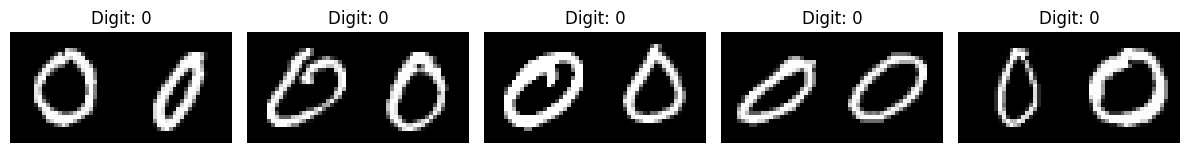

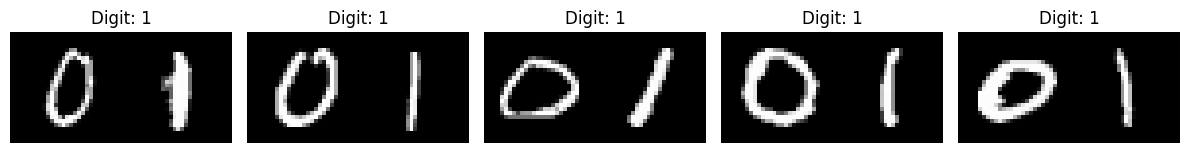

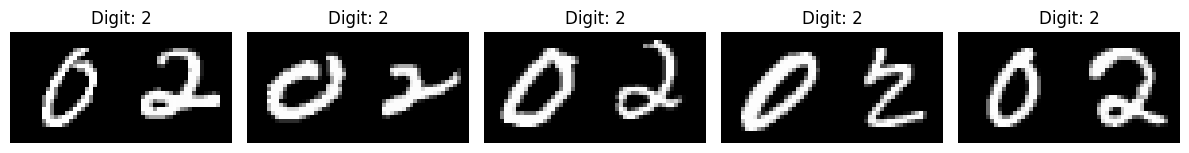

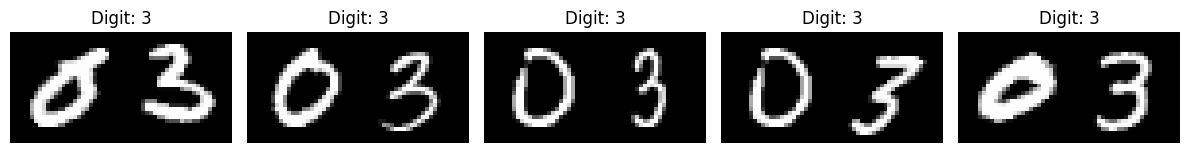

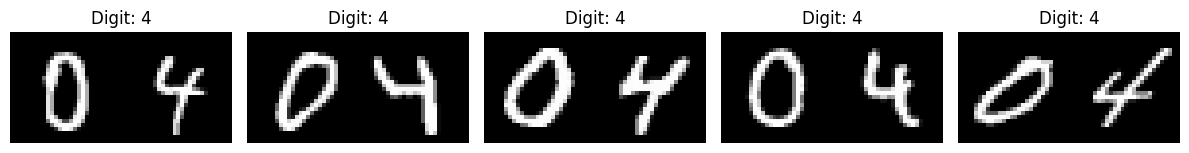

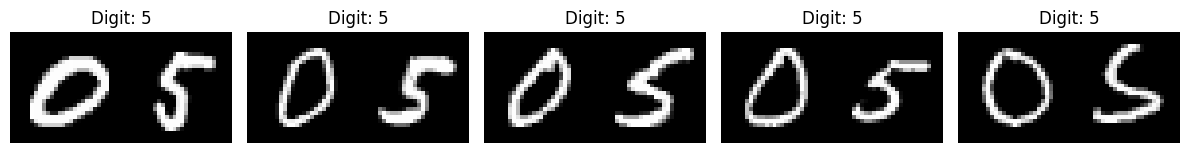

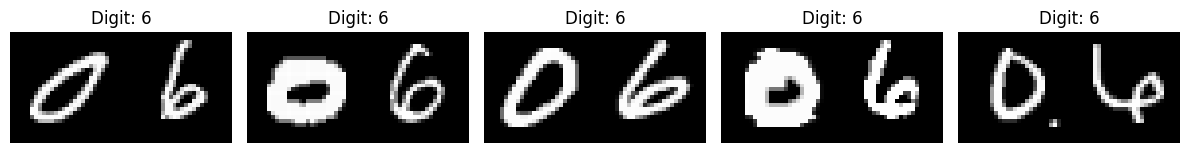

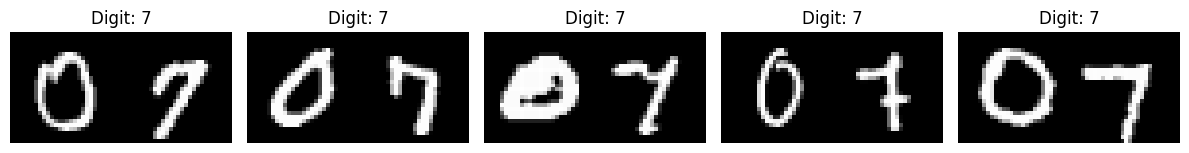

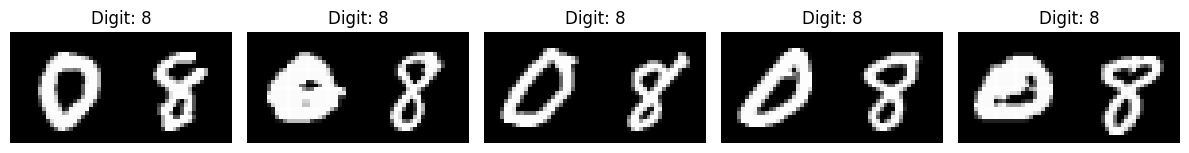

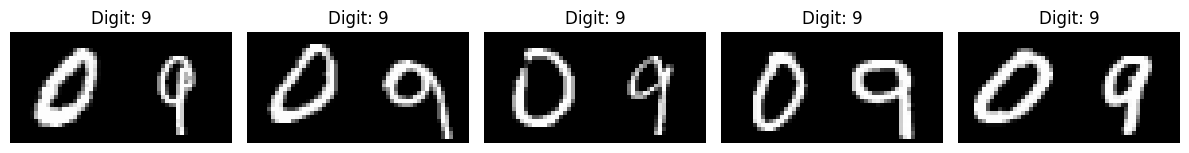

In [7]:
import random  # Import the random module for generating random numbers

def show_few_samples_of_num(num = 0):  # Define a function to display samples of a specific digit
  fig, axes = plt.subplots(1, 5, figsize=(12, 3))  # Create a figure and 5 subplots (1 row, 5 columns)
  axes = axes.ravel()  # Flatten the axes array for easy iteration
  samples_to_be_printed = 5  # Initialize the number of samples to print to 5
  num_of_samples = two_digit_train_df['label'].value_counts()[num]  # Get the total number of samples for the given digit
  if num_of_samples < samples_to_be_printed:  # If there are fewer samples than desired
    samples_to_be_printed = num_of_samples  # Adjust the number of samples to print

  for i in range(samples_to_be_printed):  # Iterate through the desired number of samples
      # Select a random image of the digit, reshape it to 28x56
      img = two_digit_train_df[two_digit_train_df['label'] == num].iloc[random.randint(0, num_of_samples), 1:].values.reshape(28, 56)
      axes[i].imshow(img, cmap='gray')  # Display the image on the subplot with a grayscale colormap
      axes[i].set_title(f"Digit: {num}")  # Set the title of the subplot to indicate the digit
      axes[i].axis('off')  # Hide axis ticks and labels

  plt.tight_layout()  # Adjust subplot spacing
  plt.show()  # Display the plot

for i in range(10):  # Iterate through digits 0 to 9
  show_few_samples_of_num(i)  # Call the function to display samples for each digit

## Data Preprocessing
To prepare the data for training, we normalize the pixel values and reshape the images.
Normalization helps improve model convergence.


In [8]:
# Separate features and labels
X_2d_train = two_digit_train_df.drop(columns=['label']).values
y_2d_train = two_digit_train_df['label'].values

# Normalize the data
X_2d_train = X_2d_train / 255.0
two_digit_test_df = two_digit_test_df / 255.0

# Reshape the data to include the channel dimension
X_2d_train = X_2d_train.reshape(-1, 28, 56, 1)
two_digit_test_df = two_digit_test_df.values.reshape(-1, 28, 56, 1)

# One-hot encode the labels
y_2d_train = to_categorical(y_2d_train, num_classes=100)

# Display shape of preprocessed data
X_2d_train.shape, y_2d_train.shape


((99000, 28, 56, 1), (99000, 100))

## Exploratory Data Analysis (EDA) & Visualization  
Before diving into model training, we perform a quick EDA to understand the *shape*, *pixel-intensity distribution*, and *class balance* of our **two-digit MNIST** dataset.

* **Pixel-intensity histograms** – reveal whether the images are well-normalized and highlight any skew (e.g., many near-zero values).  
* **Class-balance bar chart** – confirms the distribution of two-digit labels and flags any imbalance that could bias the model.

> **Note**  
> *For the two-digit dataset, labels are strings like `"07"` or integers 0-99 stored in `y_train`. Modify the label parsing below if you use another format.*

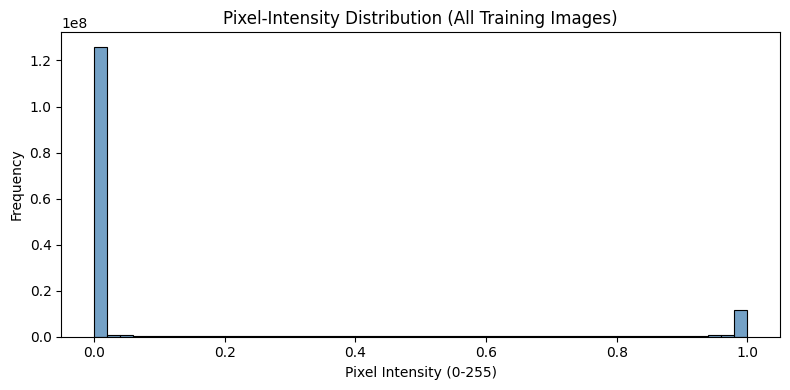

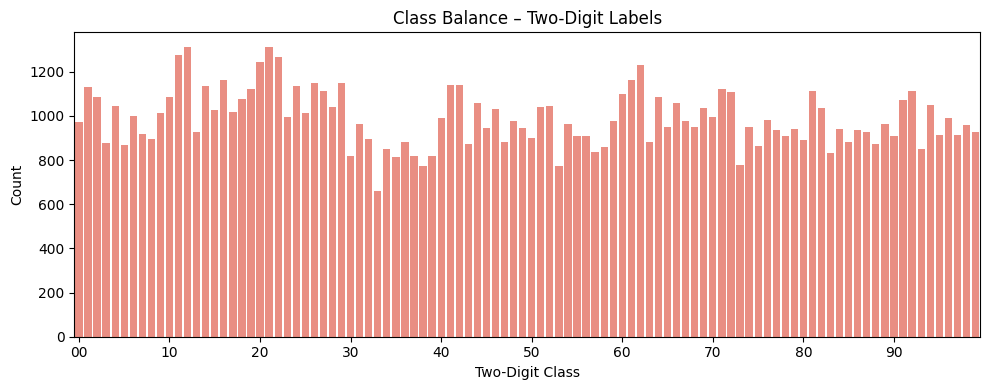

Max : Min class count ratio = 2.00


In [9]:
# --- Imports ---------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --------------------------------------------------------------------------
# ---------------------- Pixel-Intensity Histogram --------------------------
# Corrected variable names from X_train and y_train to X_2d_train and y_2d_train
flat_pixels = X_2d_train.reshape(len(X_2d_train), -1)   # (n_samples, 28*56)
all_pixels = flat_pixels.flatten()

plt.figure(figsize=(8, 4))
sns.histplot(all_pixels, bins=50, kde=False, color="steelblue")
plt.title("Pixel-Intensity Distribution (All Training Images)")
plt.xlabel("Pixel Intensity (0-255)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ------------------------ Class-Balance Chart ------------------------------
# Convert labels to string (e.g., '07'), ensuring two digits
# Corrected variable names from X_train and y_train to X_2d_train and y_2d_train
# y_2d_train is already one-hot encoded. We need to convert it back to integer labels for this plot.
y_2d_train_int = np.argmax(y_2d_train, axis=1)
labels_2d = pd.Series([f"{d:02d}" for d in y_2d_train_int])

plt.figure(figsize=(10, 4))
order = labels_2d.value_counts().sort_index()  # keep 00, 01, ..., 99 order
sns.barplot(x=order.index, y=order.values, color="salmon")
plt.title("Class Balance – Two-Digit Labels")
plt.xlabel("Two-Digit Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(0, 100, 10), labels=[f"{i:02d}" for i in range(0, 100, 10)])
plt.tight_layout()
plt.show()

# Print quick balance stats
imbalance_ratio = order.max() / order.min()
print(f"Max : Min class count ratio = {imbalance_ratio:.2f}")

## Model building

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Build the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 56, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(100, activation='softmax')
])

# Display the model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 54, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 27, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 12, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       491,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523,364 (2.00 MB)

 Trainable params: 523,364 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

## Display the model in graphical format for better depiction

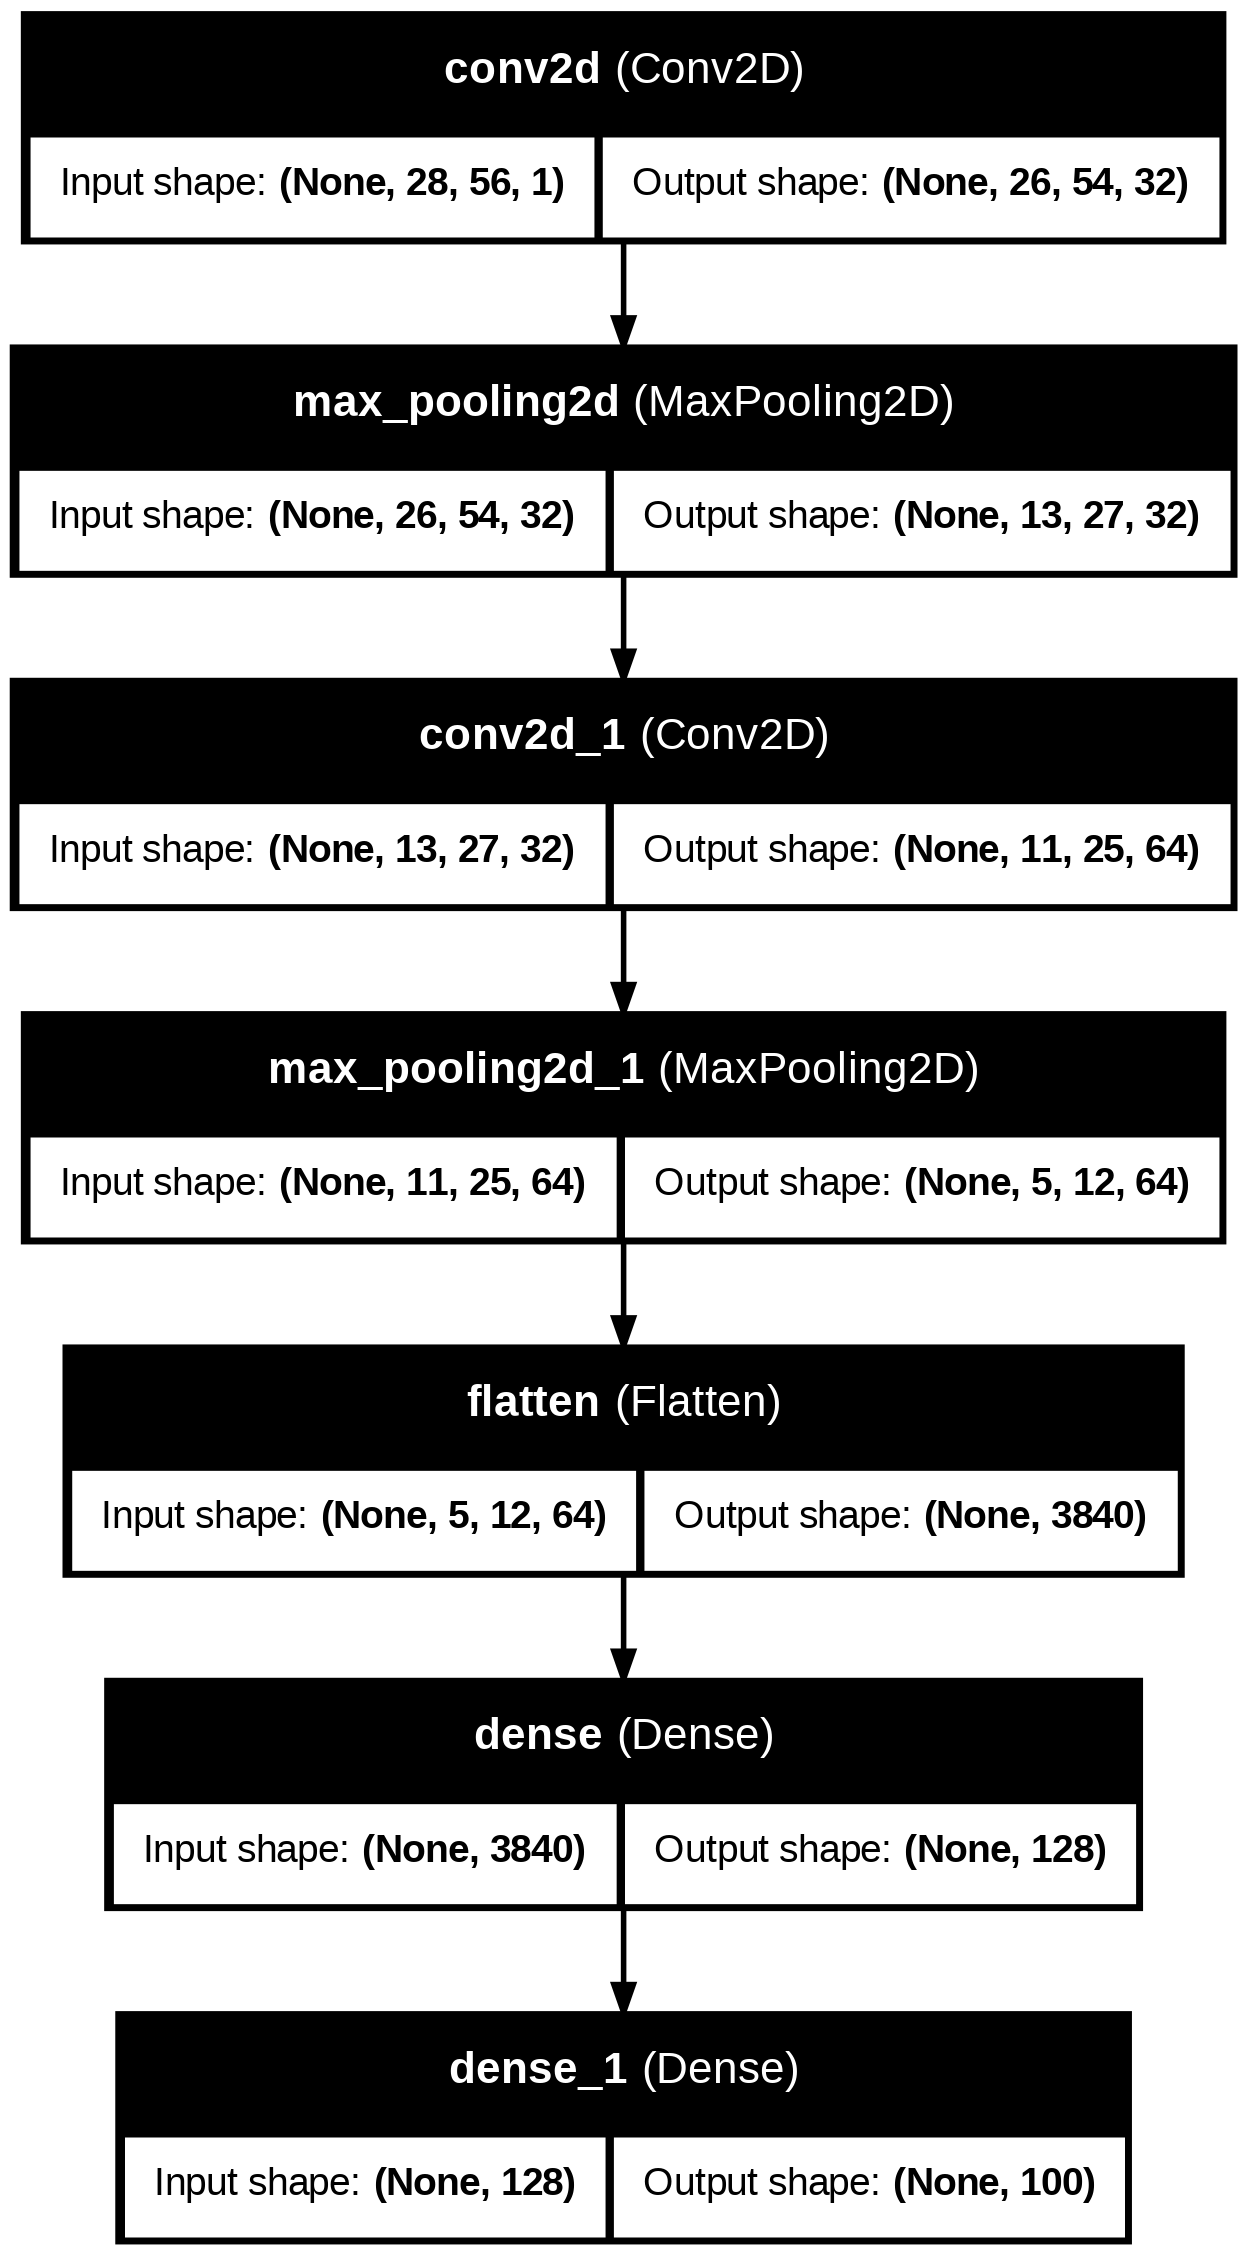

In [11]:
from tensorflow.keras.utils import plot_model
# Generate a plot of the model
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Model training

In [13]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_2d_train, y_2d_train, epochs=40, batch_size=200, validation_split=0.2)

Epoch 1/40
396/396 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.0086 - loss: nan - val_accuracy: 0.0082 - val_loss: nan
Epoch 2/40
396/396 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0094 - loss: nan - val_accuracy: 0.0082 - val_loss: nan
Epoch 3/40
396/396 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0094 - loss: nan - val_accuracy: 0.0082 - val_loss: nan
Epoch 4/40
396/396 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0085 - loss: nan - val_accuracy: 0.0082 - val_loss: nan
Epoch 5/40
396/396 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0094 - loss: nan - val_accuracy: 0.0082 - val_loss: nan
Epoch 6/40
396/396 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0093 - loss: nan - val_accuracy: 0.0082 - val_loss: nan
Epoch 7/40
396/396 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0084 - loss: nan - val_accuracy: 0.0082 - val_loss: nan
Epoch 8/40
396/396 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0089 - loss: nan - val_accuracy: 0.0082 - val_loss: nan
Epoch 9/40
396/396 ━━━━

## Save this two digit model and history param for future use

In [14]:
# Save the model
#model.save('twoDigitRecogCNN_model.h5')
# load this model like the following for future use
from tensorflow.keras.models import load_model
# Load the model
model = load_model('/content/drive/My Drive/Colab Notebooks/twoDigRecognizeCNN/twoDigitRecogCNN_model.h5')
import pickle
# Save the history object
#with open('twoDigitRecogCNN_model_trainingHist.pkl', 'wb') as file:
#    pickle.dump(history.history, file)
# load this history like the following for future use
# Load the history object
with open('/content/drive/My Drive/Colab Notebooks/twoDigRecognizeCNN/twoDigitRecogCNN_model_trainingHist.pkl', 'rb') as file:
    history = pickle.load(file)

In [15]:
!ls -lh /content/drive/My\ Drive/Colab\ Notebooks/twoDigRecognizeCNN/twoDigitRecogCNN_model.h5

-rw------- 1 root root 6.1M Nov 14  2024 '/content/drive/My Drive/Colab Notebooks/twoDigRecognizeCNN/twoDigitRecogCNN_model.h5'


In [16]:
# If `loaded_history` is not a dictionary
if not isinstance(history, dict):
    history = history.history  # Access the dictionary attribute
# Convert DataFrame or Series to dictionary
if isinstance(history, pd.DataFrame) or isinstance(history, pd.Series):
    history = history.to_dict()


In [17]:
history

{'accuracy': [0.7479419112205505,
  0.9429924488067627,
  0.9660353660583496,
  0.977070689201355,
  0.9834848642349243,
  0.9892550706863403,
  0.9912374019622803,
  0.9927146434783936,
  0.9933711886405945,
  0.9943055510520935,
  0.9939772486686707,
  0.9956060647964478,
  0.9964520335197449,
  0.9962626099586487,
  0.9960101246833801,
  0.9972727298736572,
  0.9973989725112915,
  0.9976515173912048,
  0.9968813061714172,
  0.997298002243042,
  0.9979671835899353,
  0.9980681538581848,
  0.9982070922851562,
  0.9978787899017334,
  0.9979923963546753,
  0.9975631237030029,
  0.9985858798027039,
  0.9980176687240601,
  0.9989141225814819,
  0.999457061290741,
  0.9991161823272705,
  0.9973484873771667,
  0.9983964562416077,
  0.9994192123413086,
  0.9989898800849915,
  0.9975757598876953,
  0.9991413950920105,
  0.9996338486671448,
  0.9997979998588562,
  0.9983711838722229],
 'loss': [0.9507808685302734,
  0.18578825891017914,
  0.10996650159358978,
  0.0724782645702362,
  0.05132203

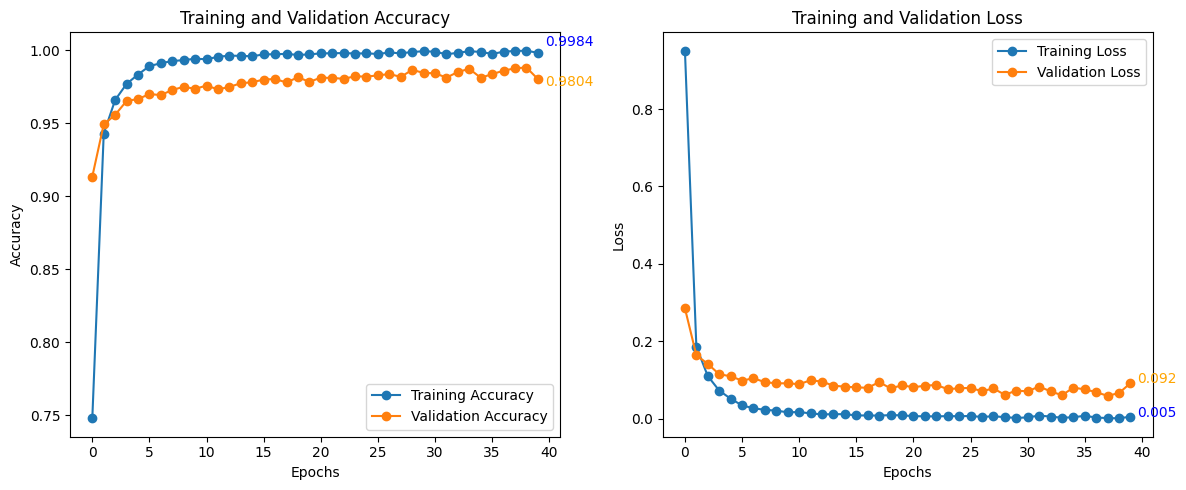

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], marker='o', label='Training Accuracy')
plt.plot(history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Annotate only the last point for accuracy and validation accuracy
last_epoch = len(history['accuracy']) - 1
plt.annotate(f'{history["accuracy"][-1]:.4f}',
             xy=(last_epoch, history['accuracy'][-1]),
             xytext=(5, 5), textcoords='offset points', color='blue')
plt.annotate(f'{history["val_accuracy"][-1]:.4f}',
             xy=(last_epoch, history['val_accuracy'][-1]),
             xytext=(5, -5), textcoords='offset points', color='orange')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], marker='o', label='Training Loss')
plt.plot(history['val_loss'], marker='o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Annotate only the last point for loss and validation loss
plt.annotate(f'{history["loss"][-1]:.3f}',
             xy=(last_epoch, history['loss'][-1]),
             xytext=(5, 0), textcoords='offset points', color='blue')
plt.annotate(f'{history["val_loss"][-1]:.3f}',
             xy=(last_epoch, history['val_loss'][-1]),
             xytext=(5, 0), textcoords='offset points', color='orange')

plt.tight_layout()
plt.show()

In [19]:
#y_2d_train.values
unique_values, counts = np.unique(y_2d_train, return_counts=True)

# Combine the results in a readable format (optional)
value_counts = dict(zip(unique_values, counts))
print(value_counts)


{np.float64(0.0): np.int64(9801000), np.float64(1.0): np.int64(99000)}


In [20]:
#two_digit_train_df['label'].values
to_categorical(two_digit_train_df['label'].values, num_classes=100).shape

(99000, 100)

In [21]:
## Final value of lost and accuracy for both training and validation dateset after 40 epochs
print(f"Final Training Accuracy: {history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")

Final Training Accuracy: 0.9984
Final Validation Accuracy: 0.9804
Final Training Loss: 0.0051
Final Validation Loss: 0.0917


## Making Predictions for two digit recognition
Finally, I make predictions on the test data and prepare a CSV file to store the result



In [22]:
# Predict on the test data
predictions = model.predict(two_digit_test_df)
predicted_labels = np.argmax(predictions, axis=1)

# Prepare submission
submission = pd.DataFrame({'ImageId': np.arange(1, len(predicted_labels) + 1), 'Label': predicted_labels})
submission.to_csv('submission_2d.csv', index=False)
submission.head()

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


,ImageId,Label
0,1,25
1,2,12
2,3,69
3,4,49
4,5,22


In [23]:
two_digit_test_df.shape

(20000, 28, 56, 1)

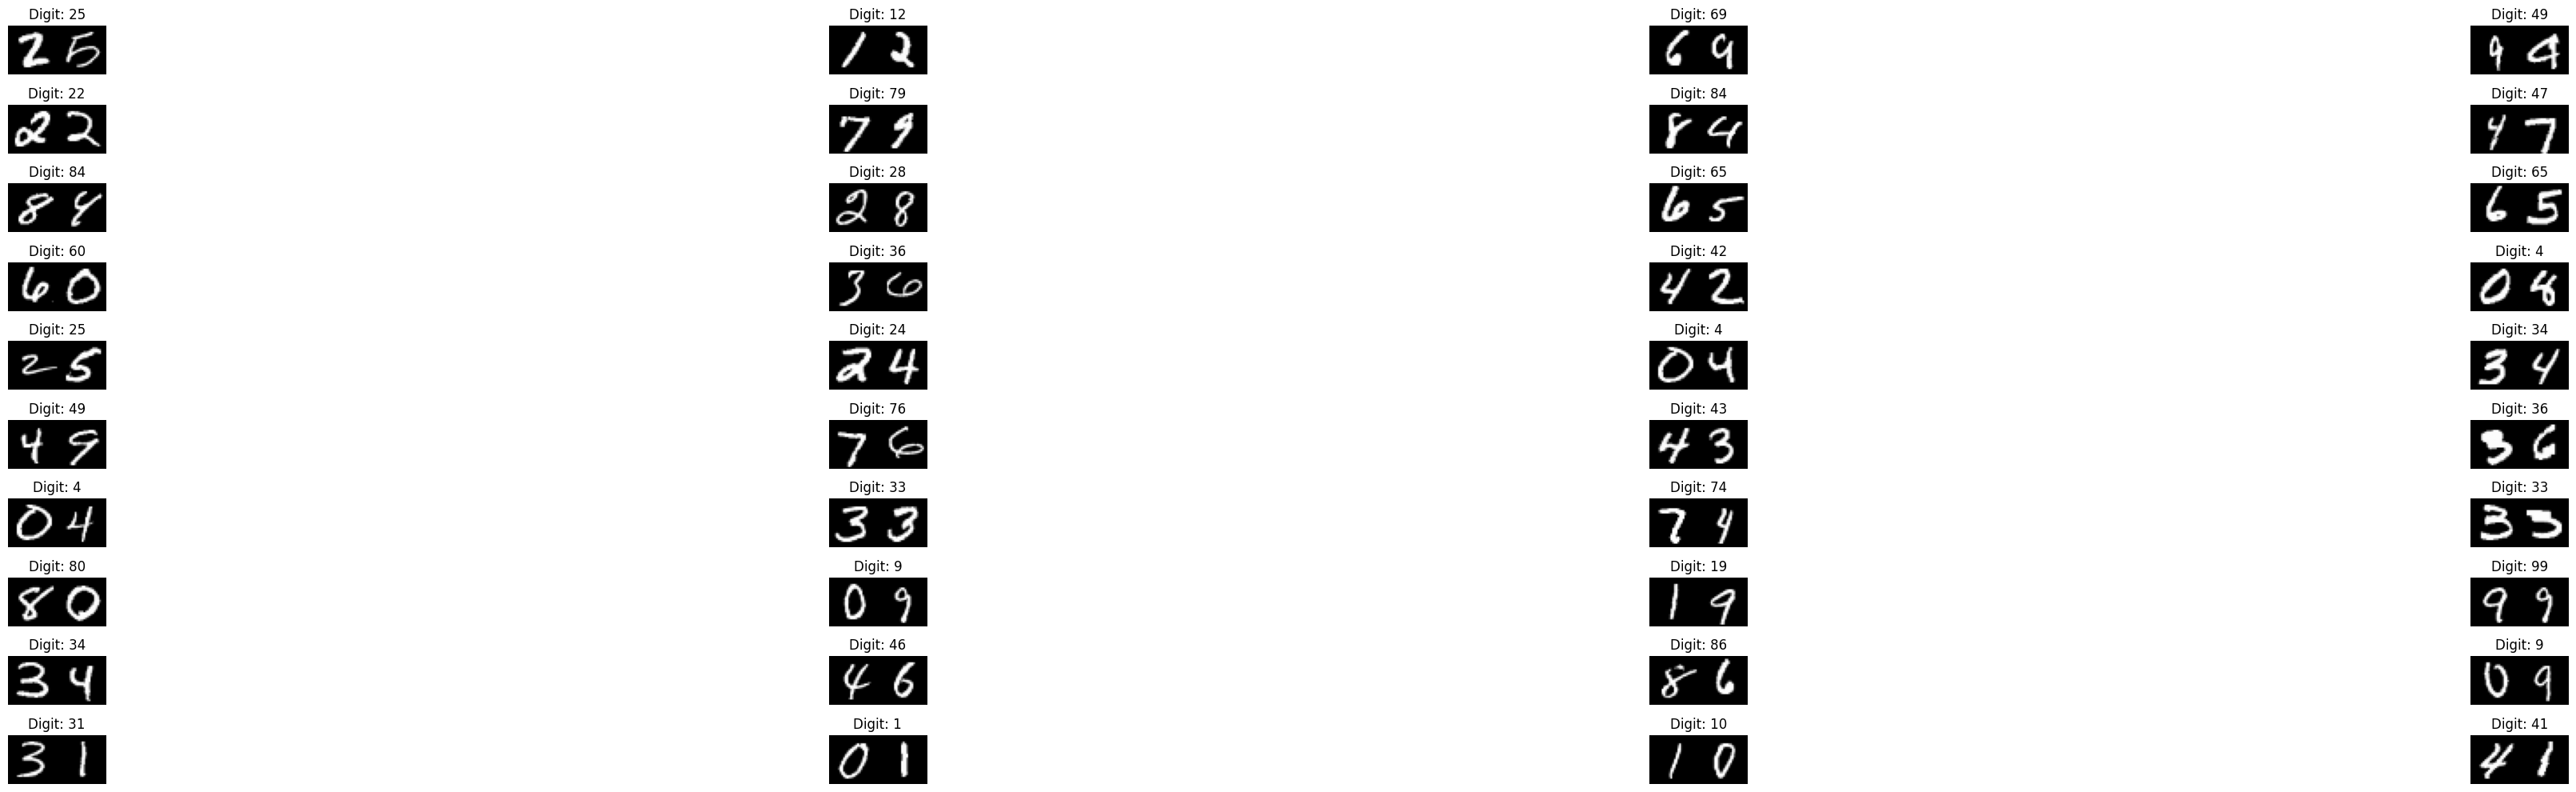

In [24]:
# prompt: Using dataframe submission: print 5 random image from two_digit_test_df and their prediction from submission
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
import random
import math
# Assuming 'two_digit_test_df' is a dataframe with an 'ImageId' column
# and a way to access the image data (e.g., a 'path' column or a method).
# Replace 'path' with the actual column or method that references the image.


def show_random_images_and_predictions(ndarray, prediction, num_images=10):
    """
    Displays random images along with their predicted labels.
    """
    fig, axes = plt.subplots(math.ceil(num_images/4), 4, figsize=(48, 10))
    axes = axes.ravel()

    for i in range(num_images):
      imageId = prediction.iloc[i, 0]
      imageLabel = prediction.iloc[i, 1]
      # Convert the image data to the correct data type (e.g., float64)
      img = ndarray[imageId - 1].astype(np.float64).reshape(28, 56)
      axes[i].imshow(img, cmap='gray')
      axes[i].set_title(f"Digit: {imageLabel}")
      axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function
show_random_images_and_predictions(two_digit_test_df, submission, num_images=40)

## Error Analysis – Visualising the Top-*K* Mis-Classifications  
Understanding *why* a model fails is as important as tracking its accuracy.  
Here we:  

1. **Collect all mis-classified samples** on the test set.  
2. **Rank them** by the model’s confidence in its (wrong) prediction.  
3. **Display the top-*K*** errors in a grid, with the predicted label, the true label, and the model’s confidence score.

This helps identify systematic failure modes (e.g., specific digit pairs like `18 ↔ 13`) and guides targeted data augmentation or architectural tweaks.


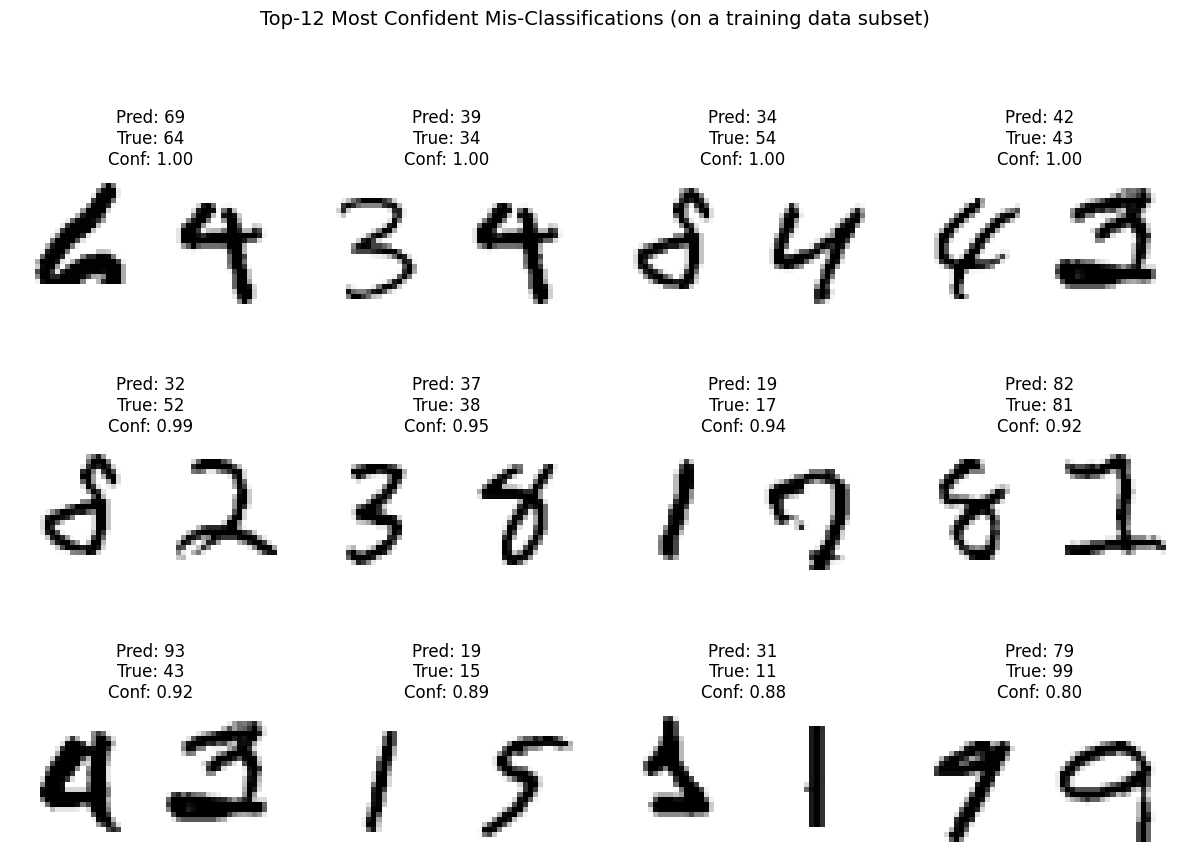

In [28]:
# --------------------------------------------------------------------------
# Assumptions:
# * X_data  : np.ndarray of shape (n_samples, 28, 56, 1)
# * y_data  : 1-D array / list  of true integer labels (0-99)
# * model   : trained Keras / TF model returning softmax probs for 100 classes
# --------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

# For demonstration purposes, we will use a subset of the training data
# as if it were a test set with known labels.
# In a real scenario, you would use a separate validation set for this analysis.

# Ensure X_2d_train and y_2d_train_int are available from previous steps
# (X_2d_train was created by dropping the label from the train dataframe and reshaping)
# (y_2d_train_int was created by argmax on the one-hot encoded training labels)

# Select a subset of the training data to simulate a test set with labels
subset_size = 1000 # Adjust the size as needed
subset_indices = np.random.choice(len(X_2d_train), subset_size, replace=False)

X_data_subset = X_2d_train[subset_indices]
y_data_subset = y_2d_train_int[subset_indices]


# --------------------- Generate Predictions -------------------------------
# Use the selected subset of data for prediction
probs = model.predict(X_data_subset, verbose=0)               # shape: (n_subset, 100)
y_pred = probs.argmax(axis=1)
conf_pred = probs.max(axis=1)                          # confidence of chosen class

# --------------------- Identify Mis-Classifications -----------------------
# Use the true labels from the subset for comparison
mis_idx = np.where(y_pred != y_data_subset)[0]
mis_conf = conf_pred[mis_idx]
mis_sorted = mis_idx[np.argsort(-mis_conf)]            # sort descending by confidence

# --------------------- Visualise Top-K Errors -----------------------------
TOP_K = 12                                            # change as desired
# Ensure we don't try to display more errors than exist
TOP_K = min(TOP_K, len(mis_sorted))
top_k_idx = mis_sorted[:TOP_K]

if TOP_K == 0:
    print("No misclassifications found in the selected subset.")
else:
    n_cols = 4
    n_rows = int(np.ceil(TOP_K / n_cols))
    plt.figure(figsize=(3*n_cols, 3*n_rows))

    for i, idx in enumerate(top_k_idx, 1):
        # Access the image from the subset using the original subset index
        img   = X_data_subset[idx].squeeze()        # remove channel dim if present
        true  = int(y_data_subset[idx])             # Get true label from subset
        pred  = int(y_pred[idx])
        # Find the confidence of the specific misclassified item
        conf  = mis_conf[np.where(mis_idx == idx)][0]


        plt.subplot(n_rows, n_cols, i)
        plt.imshow(img, cmap="gray_r")
        plt.title(f"Pred: {pred:02d}\nTrue: {true:02d}\nConf: {conf:.2f}")
        plt.axis("off")

    plt.suptitle(f"Top-{TOP_K} Most Confident Mis-Classifications (on a training data subset)", fontsize=14, y=1.03)
    plt.tight_layout()
    plt.show()